<a href="https://colab.research.google.com/github/PoulYak/EVRAZ/blob/main/EVRAZ_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error

In [2]:
data = pd.read_csv('data.csv', sep=';', index_col=0, decimal=',')
data.head()

,nplv,DT,МАРКА,ПРОФИЛЬ,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,...,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,г6837?3<87?,2070-06-21 00:14:00,Э76ХФ,Р65,29.0,45.366667,24.400000,41.033333,NaN,0.456460,0.059572,0.117446,0.104762,0.040938,1557.0,1580.0,13.606742,NaN,12809.016393,115.5,1.0,1.0,1.0,18.611,NaN,NaN,NaN,NaN,0.170,NaN,0.401,0.123,0.02,NaN,NaN,NaN,0.051939,0.112,NaN,0.182,...,0.389,0.368,0.127,0.682,0.010,0.011,0.086,0.009,0.023,0.459,0.002,0.002,0.003,0.756,0.0001,0.417,0.126,0.779,0.009,0.012,0.086,0.011,0.018,0.559,0.003,0.037,NaN,63.7,1.1,3.7,0.12,2.6,NaN,NaN,53.4,1.0,5.8,0.15,2.6,NaN
1,г683863<886,2070-06-21 01:07:00,Э76ХФ,Р65,26.0,44.066667,13.866667,44.066667,NaN,0.359285,0.083738,0.160923,0.110327,0.040083,1601.0,1591.0,8.074721,NaN,12816.346154,111.6,1.0,1.0,1.0,11.659,NaN,NaN,NaN,NaN,0.488,NaN,NaN,0.094,0.02,NaN,NaN,NaN,0.050854,0.102,NaN,0.251,...,0.465,0.345,0.112,0.643,0.009,0.011,0.080,0.007,0.023,0.461,0.002,0.002,0.003,0.774,0.0003,0.416,0.109,0.767,0.008,0.013,0.079,0.008,0.021,0.543,0.003,0.038,NaN,58.5,0.8,4.9,0.14,2.2,NaN,NaN,59.3,0.6,4.1,0.11,2.3,NaN
2,г683863<887,2070-06-21 02:00:00,Э76ХФ,Р65,24.0,43.350000,17.950000,43.350000,NaN,0.331665,0.081490,0.132332,0.139860,0.041622,1593.0,1586.0,13.801968,NaN,12511.420613,115.8,1.0,1.0,1.0,19.871,NaN,NaN,NaN,NaN,0.050,NaN,0.346,0.061,0.02,NaN,NaN,NaN,0.052807,0.160,NaN,0.204,...,0.513,0.351,0.107,0.674,0.007,0.011,0.078,0.008,0.019,0.455,0.002,0.002,0.004,0.770,0.0009,0.417,0.108,0.788,0.006,0.012,0.078,0.008,0.013,0.568,0.003,0.038,NaN,58.0,0.8,8.6,0.12,2.6,NaN,NaN,57.2,0.5,8.1,0.13,2.3,NaN
3,г683863<888,2070-06-21 02:58:00,Э76ХФ,Р65,17.0,46.183333,19.816667,46.183333,NaN,0.377945,0.133194,0.221605,0.165186,0.042050,1589.0,1589.0,12.664959,NaN,12998.149706,116.3,1.0,1.0,1.0,19.497,NaN,NaN,0.077,NaN,0.050,NaN,0.390,0.059,0.02,NaN,NaN,NaN,0.053349,0.161,NaN,0.345,...,0.487,0.310,0.105,0.611,0.009,0.011,0.070,0.006,0.020,0.434,0.001,0.001,0.003,0.767,0.0002,0.419,0.103,0.795,0.008,0.013,0.070,0.007,0.014,0.571,0.003,0.038,NaN,59.8,0.4,6.4,0.11,2.4,NaN,NaN,60.3,0.5,6.3,0.12,2.6,NaN
4,г683863<889,2070-06-21 03:50:00,Э76ХФ,Р65,20.0,48.500000,17.033333,48.500000,NaN,0.389875,0.105094,0.169459,0.143024,0.040967,1597.0,1592.0,10.298350,NaN,12987.475538,115.0,1.0,1.0,1.0,16.649,NaN,NaN,0.082,NaN,0.050,NaN,0.412,0.035,0.02,NaN,NaN,NaN,0.051975,0.149,NaN,0.263,...,0.461,0.334,0.105,0.652,0.007,0.011,0.080,0.007,0.020,0.447,0.001,0.002,0.003,0.784,0.0003,0.421,0.105,0.796,0.006,0.013,0.081,0.008,0.017,0.568,0.003,0.037,NaN,59.6,0.7,4.7,0.12,2.4,NaN,NaN,60.3,0.6,4.5,0.09,2.5,NaN


### Самая популярная по плавкам марка стали - Э76ХФ

In [3]:
data['МАРКА'].value_counts()

Э76ХФ     4953
Э90ХАФ    1384
Э73Ф       227
Э76Ф        86
Ш2.2        59
Э76         56
R350HT      54
900А        54
Э76ХАФ      50
R260        35
G2HH        34
Ш2Л         31
НХ           7
09Г2С        4
С345         3
С255         2
Ст3сп        1
С355         1
Name: МАРКА, dtype: int64

Уберем из выборки остальные марки стали

In [4]:
data = data[data['МАРКА']=='Э76ХФ']

In [5]:
data = data.drop(['МАРКА'], axis=1)

### 1) Пропуски

In [6]:
print('\n'.join([i+':    '+str(data.isna().sum(axis=0)[i]) for i in data.columns if data.isna().sum(axis=0)[i]>0]))
print('\nВ 80 признаках есть пропуски\n')
print('Всего пропусков',data.isna().sum(axis=1).sum())

t вып-обр:    521
t обработка:    524
t под током:    524
t продувка:    521
ПСН гр.:    1363
чист расход C:    527
чист расход Cr:    536
чист расход Mn:    530
чист расход Si:    530
чист расход V:    539
температура первая:    525
температура последняя:    525
Ar (интенс.):    521
N2 (интенс.):    4953
эл. энергия (интенс.):    524
произв жидкая сталь:    521
произв количество обработок:    521
произв  количество плавок:    521
произв количество плавок (цел):    521
расход газ Ar:    521
расход газ  N2:    4953
расход C пров.:    4440
сыпуч известь РП:    1669
сыпуч кварцит:    4948
сыпуч кокс пыль УСТК:    534
сыпуч  кокс. мелочь (сух.):    4946
сыпуч  кокс. мелочь КМ1:    608
сыпуч  шпат плав.:    837
ферспл CaC2:    647
ферспл FeMo:    4953
ферспл FeSi-75:    4953
ферспл FeV азот.:    4953
ферспл  FeV-80:    538
ферспл  Mn5Si65Al0.5:    536
ферспл  Ni H1 пласт.:    4953
ферспл SiMn18:    551
ферспл  ферванит:    4953
ферспл  фх850А:    536
эл. энергия:    524
химсталь первый Al_1

### 2) Нули

In [7]:
(data==0).sum().sum()

1

Зануляем все пропуски

In [8]:
data.fillna(0, inplace=True)

### Найдем категориальные признаки

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4953 entries, 0 to 7026
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   nplv                            4953 non-null   object 
 1   DT                              4953 non-null   object 
 2   ПРОФИЛЬ                         4953 non-null   object 
 3   t вып-обр                       4953 non-null   float64
 4   t обработка                     4953 non-null   float64
 5   t под током                     4953 non-null   float64
 6   t продувка                      4953 non-null   float64
 7   ПСН гр.                         4953 non-null   float64
 8   чист расход C                   4953 non-null   float64
 9   чист расход Cr                  4953 non-null   float64
 10  чист расход Mn                  4953 non-null   float64
 11  чист расход Si                  4953 non-null   float64
 12  чист расход V                   49

In [10]:
object_cols = ["nplv", "DT", "ПРОФИЛЬ"]

In [11]:
data[object_cols].describe()

,nplv,DT,ПРОФИЛЬ
count,4953,4953,4953
unique,4953,4953,2
top,г683863<:>?,2070-08-05 07:47:00,Р65
freq,1,1,4951


Признаки МАРКА и ПРОФИЛЬ категориальны 

In [12]:
cat_cols = ["ПРОФИЛЬ"]

Преобразуем их к категориальным

In [13]:
data = pd.concat([pd.get_dummies(data[cat_cols[0]]), data], axis=1)
data.drop(object_cols, axis=1, inplace=True)

In [14]:
target_cols = ['химшлак последний SiO2', 'химшлак последний CaO', 'химшлак последний R', 'химшлак последний Al2O3']

In [15]:
data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


Удаляем признаки с корреляцией nan

In [16]:
data.drop(['ферспл  ферванит', 'ферспл  Ni H1 пласт.', 'ферспл FeV азот.', 'ферспл FeSi-75', 'ферспл FeMo', 'расход газ  N2', 'N2 (интенс.)'], axis=1, inplace=True)
features_cols = list(data.columns[:-7])

In [27]:
data.iloc[:, :5]

,Р65,Шар заг d шара 100 мм 2 гр.,t вып-обр,t обработка,t под током
0,1,0,29.0,45.366667,24.400000
1,1,0,26.0,44.066667,13.866667
2,1,0,24.0,43.350000,17.950000
3,1,0,17.0,46.183333,19.816667
4,1,0,20.0,48.500000,17.033333
...,...,...,...,...,...
7022,1,0,33.0,42.200000,17.850000
7023,1,0,34.0,42.050000,18.533333
7024,1,0,13.0,47.850000,20.750000
7025,1,0,14.0,40.683333,18.633333


### 3) Дисперсия 

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
XPCAreduced = pca.fit_transform(np.transpose(data))

In [18]:
print('Mean vector: ', pca.mean_)
print('Projection: ', pca.components_)
print('Explained variance ratio: ', pca.explained_variance_ratio_)

Mean vector:  [287.83513804 258.3131118  264.80936343 ... 285.39644068 290.67201974
 276.5353219 ]
Projection:  [[0.01505108 0.01430375 0.0142576  ... 0.01523005 0.01582999 0.01462301]]
Explained variance ratio:  [0.99522341]


### 4) Выбросы
Находим выбросы с помощью кластеризации

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


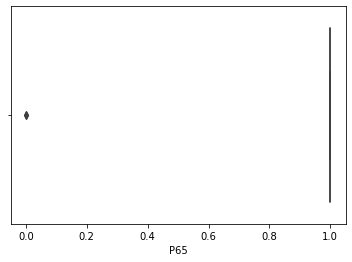

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


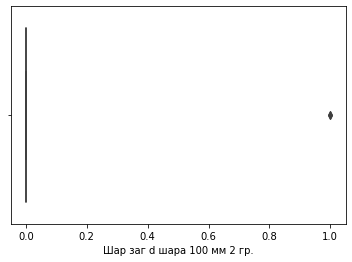

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


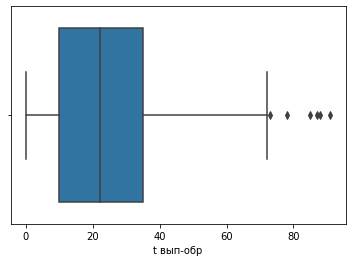

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


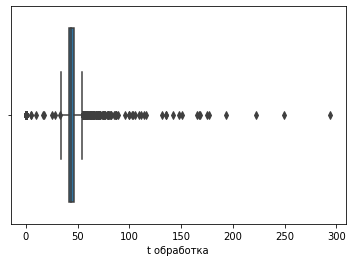

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


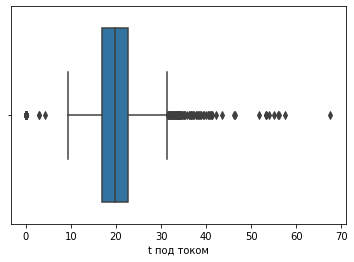

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


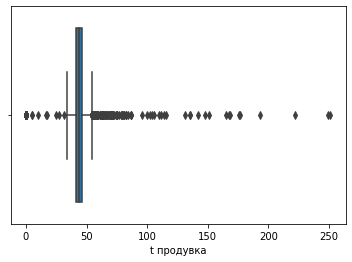

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


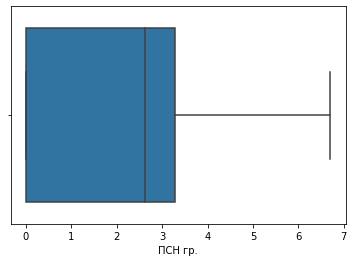

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


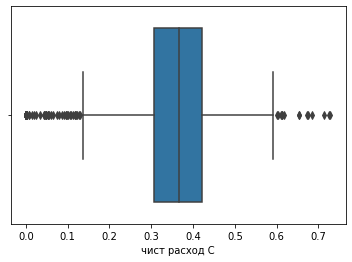

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


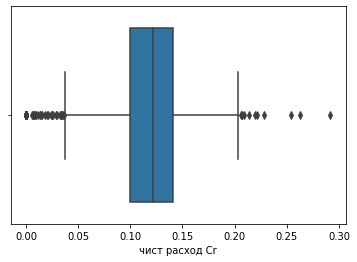

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


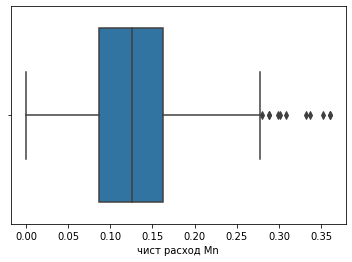

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


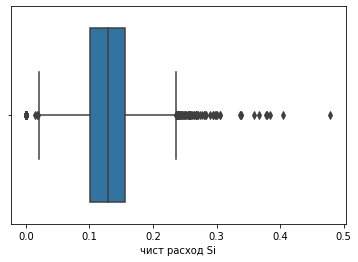

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


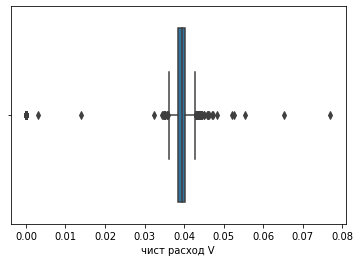

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


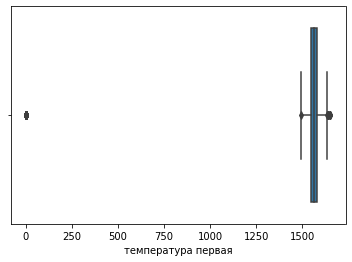

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


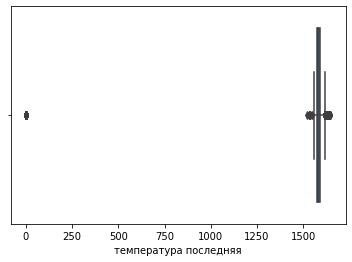

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


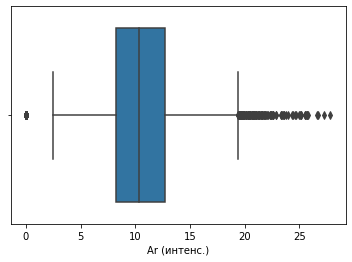

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


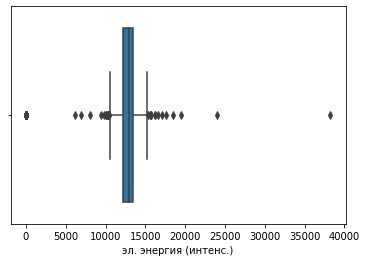

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


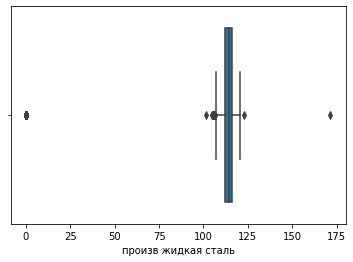

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


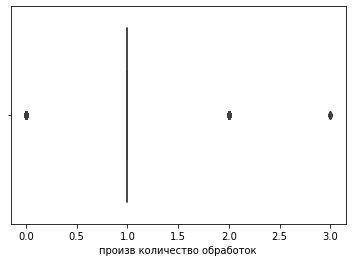

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


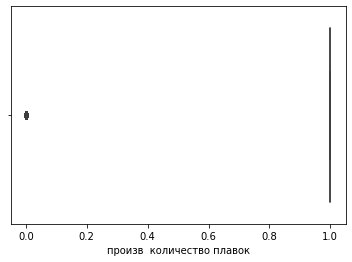

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


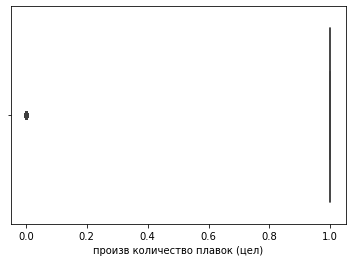

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


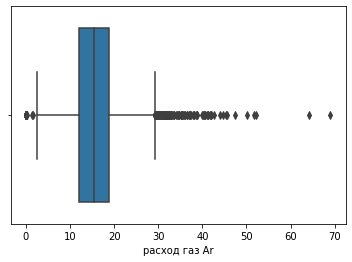

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


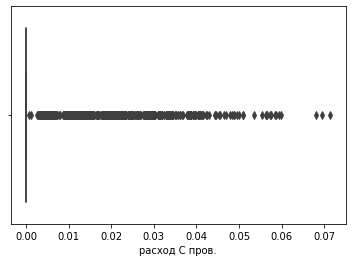

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


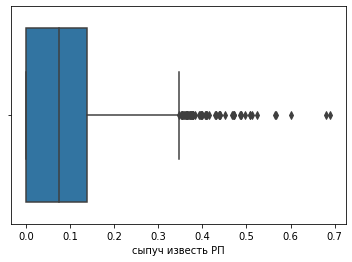

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


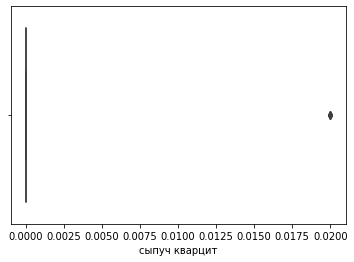

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


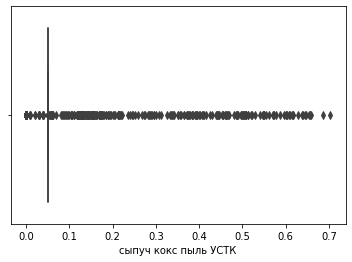

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


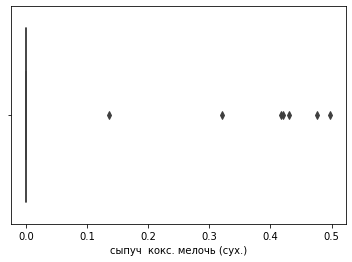

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


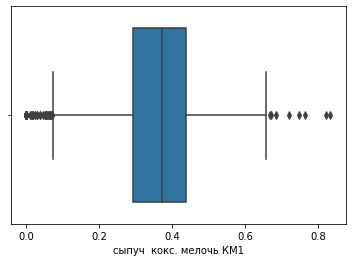

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


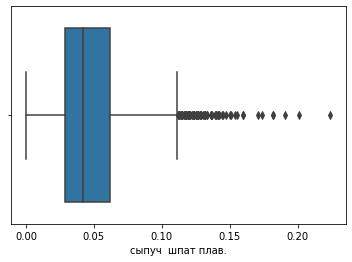

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


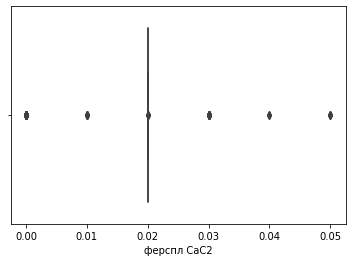

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


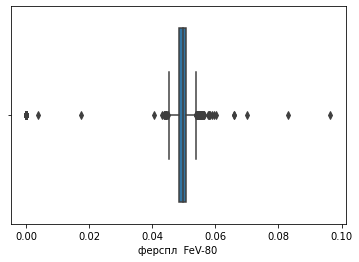

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


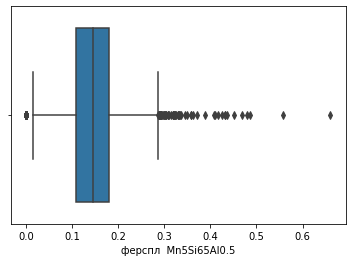

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


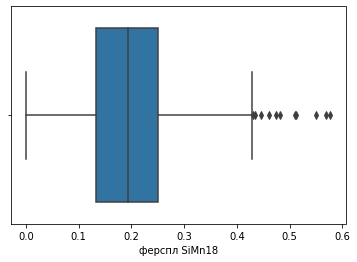

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


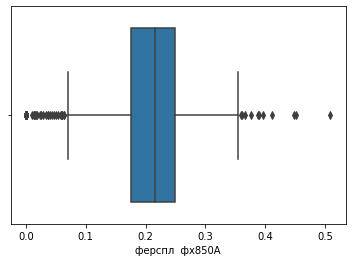

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


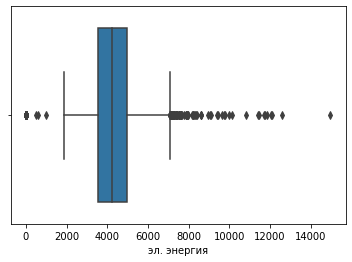

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


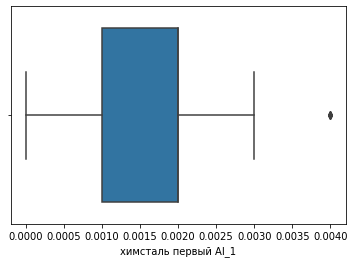

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


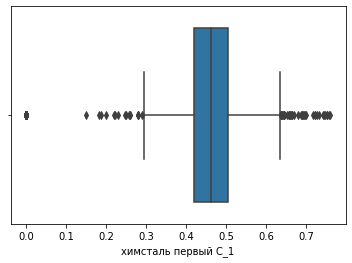

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


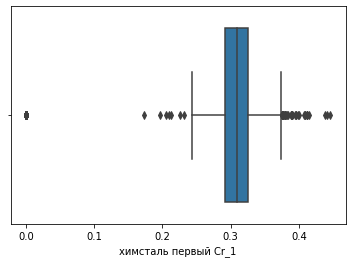

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


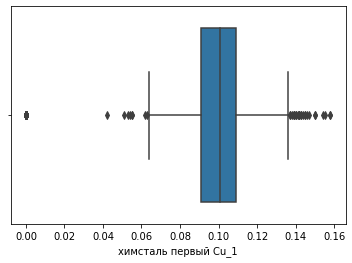

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


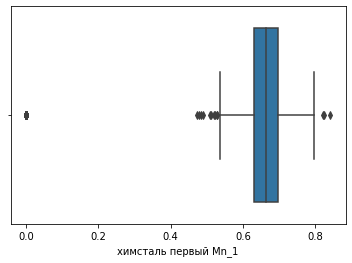

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


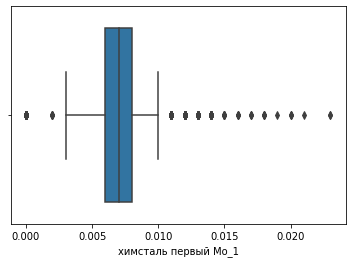

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


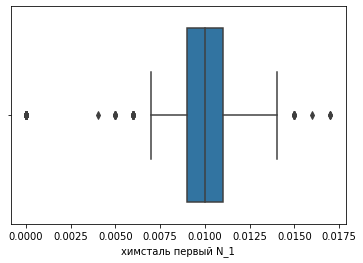

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


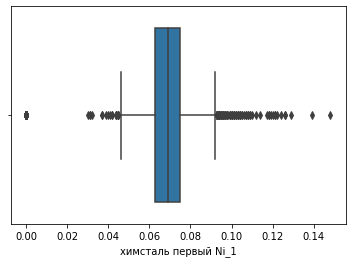

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


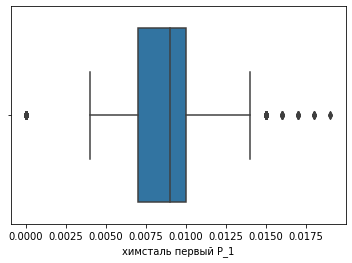

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


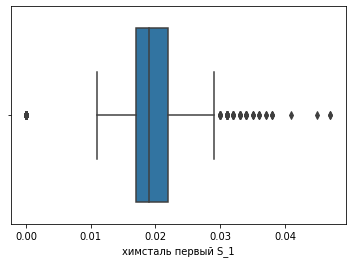

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


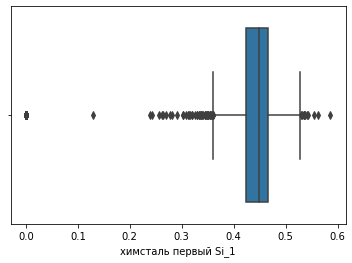

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


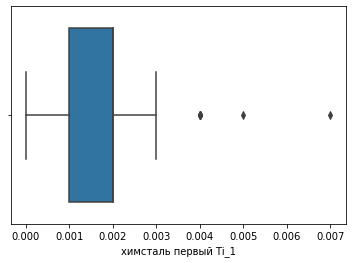

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


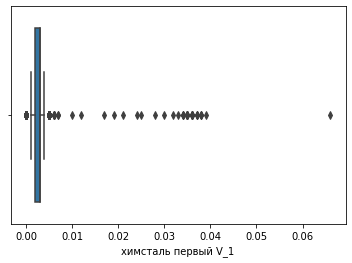

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


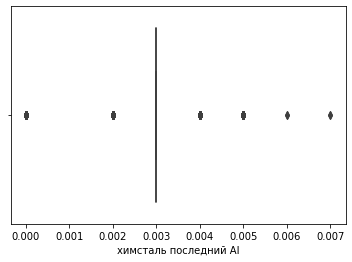

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


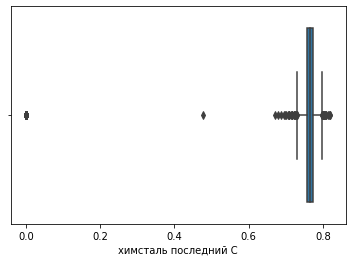

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


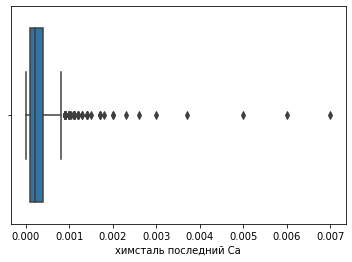

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


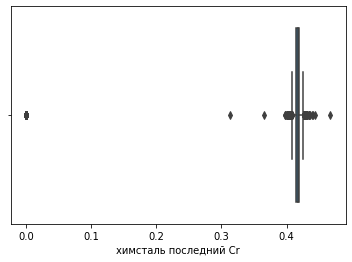

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


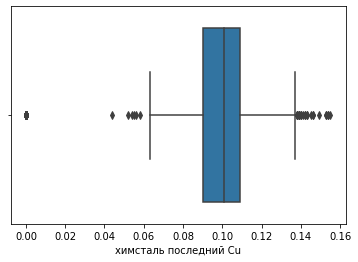

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


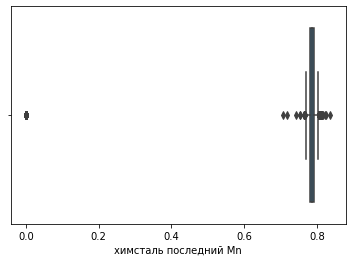

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


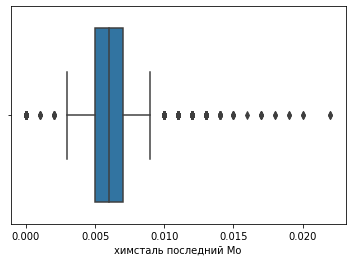

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


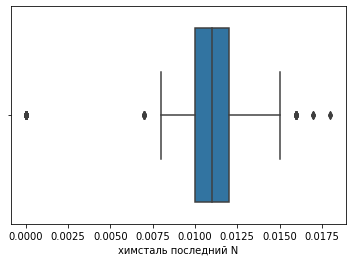

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


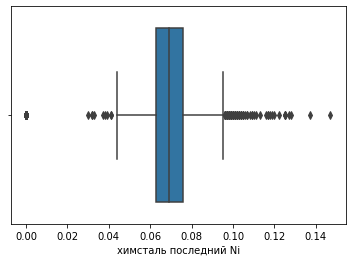

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


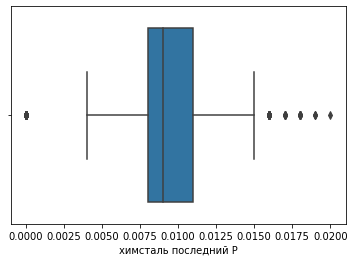

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


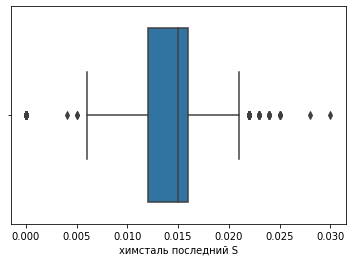

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


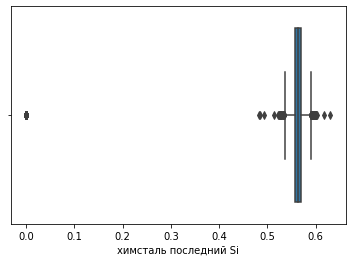

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


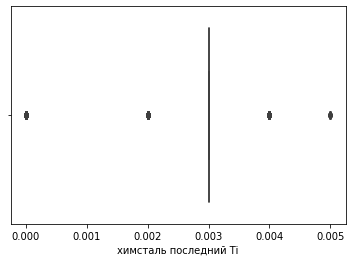

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


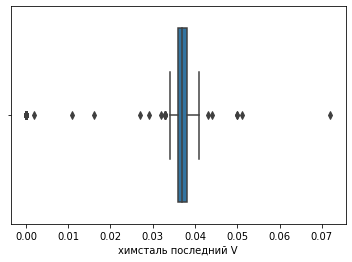

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


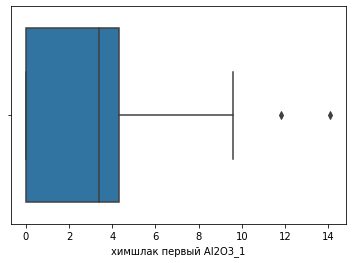

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


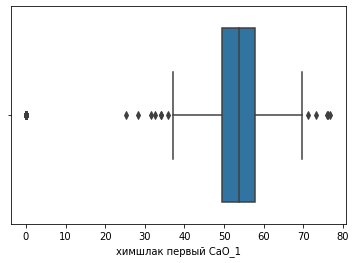

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


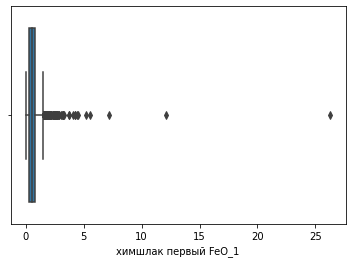

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


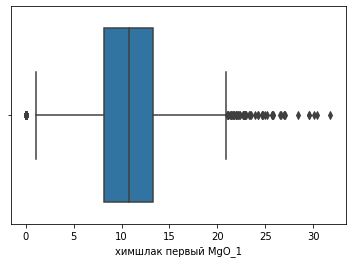

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


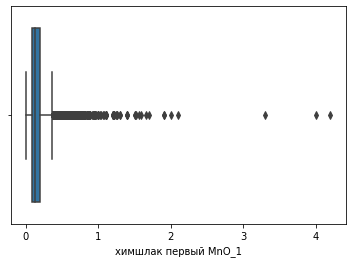

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


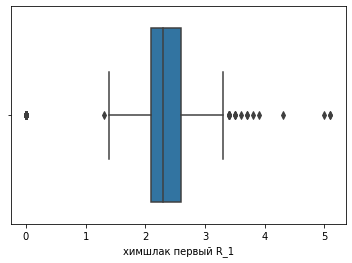

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


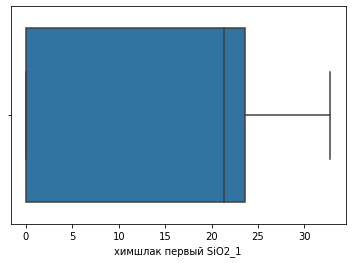

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


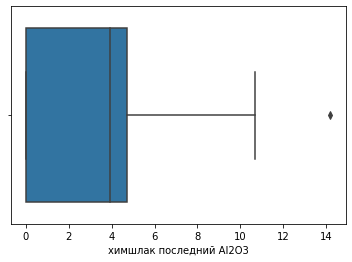

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


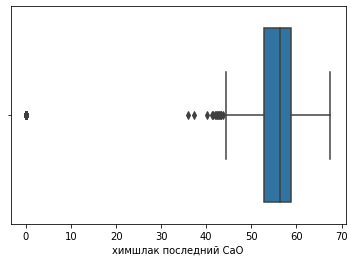

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


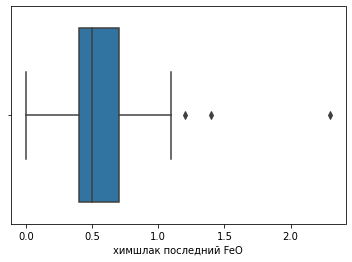

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


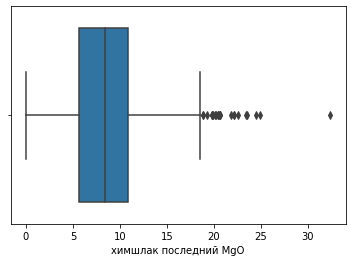

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


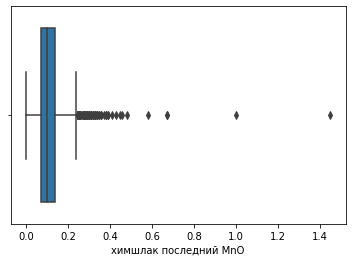

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


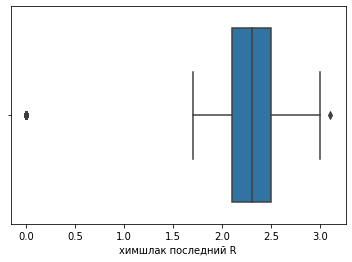

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


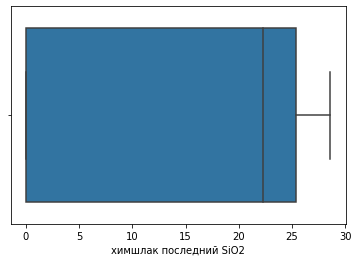

In [80]:
for k in data.columns:
    sns.boxplot(data[k])
    plt.xlabel(k)
    plt.show()

In [19]:
from sklearn.cluster import DBSCAN

outlier_detection = DBSCAN(min_samples = 2, eps = 200)
clusters = outlier_detection.fit_predict(data)
list(clusters).count(-1)

88

In [ ]:
data = data[clusters==0]

In [ ]:
data.to_csv('dataprep.csv')

In [ ]:
data = data[features_cols+target_cols]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
data_np = np.array(data)
data_sc = pd.DataFrame(scaler.fit_transform(data_np), columns=data.columns)
X, y = data_sc[features_cols], data_sc[target_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [ ]:
data

,Р65,Шар заг d шара 100 мм 2 гр.,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл SiMn18,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний SiO2,химшлак последний CaO,химшлак последний R,химшлак последний Al2O3
0,1,0,29.0,45.366667,24.400000,41.033333,0.000000,0.456460,0.059572,0.117446,0.104762,0.040938,1557.0,1580.0,13.606742,12809.016393,115.5,1.0,1.0,1.0,18.611,0.0,0.000,0.0,0.170,0.0,0.401,0.123,0.02,0.051939,0.112,0.182,0.106,5209.0,0.002,0.389,0.368,0.127,0.682,0.010,0.011,0.086,0.009,0.023,0.459,0.002,0.002,0.003,0.756,0.0001,0.417,0.126,0.779,0.009,0.012,0.086,0.011,0.018,0.559,0.003,0.037,0.0,63.7,1.1,3.7,0.12,2.6,0.0,0.0,53.4,2.6,0.0
1,1,0,26.0,44.066667,13.866667,44.066667,0.000000,0.359285,0.083738,0.160923,0.110327,0.040083,1601.0,1591.0,8.074721,12816.346154,111.6,1.0,1.0,1.0,11.659,0.0,0.000,0.0,0.488,0.0,0.000,0.094,0.02,0.050854,0.102,0.251,0.149,2962.0,0.002,0.465,0.345,0.112,0.643,0.009,0.011,0.080,0.007,0.023,0.461,0.002,0.002,0.003,0.774,0.0003,0.416,0.109,0.767,0.008,0.013,0.079,0.008,0.021,0.543,0.003,0.038,0.0,58.5,0.8,4.9,0.14,2.2,0.0,0.0,59.3,2.3,0.0
2,1,0,24.0,43.350000,17.950000,43.350000,0.000000,0.331665,0.081490,0.132332,0.139860,0.041622,1593.0,1586.0,13.801968,12511.420613,115.8,1.0,1.0,1.0,19.871,0.0,0.000,0.0,0.050,0.0,0.346,0.061,0.02,0.052807,0.160,0.204,0.145,3743.0,0.002,0.513,0.351,0.107,0.674,0.007,0.011,0.078,0.008,0.019,0.455,0.002,0.002,0.004,0.770,0.0009,0.417,0.108,0.788,0.006,0.012,0.078,0.008,0.013,0.568,0.003,0.038,0.0,58.0,0.8,8.6,0.12,2.6,0.0,0.0,57.2,2.3,0.0
3,1,0,17.0,46.183333,19.816667,46.183333,0.000000,0.377945,0.133194,0.221605,0.165186,0.042050,1589.0,1589.0,12.664959,12998.149706,116.3,1.0,1.0,1.0,19.497,0.0,0.077,0.0,0.050,0.0,0.390,0.059,0.02,0.053349,0.161,0.345,0.237,4293.0,0.002,0.487,0.310,0.105,0.611,0.009,0.011,0.070,0.006,0.020,0.434,0.001,0.001,0.003,0.767,0.0002,0.419,0.103,0.795,0.008,0.013,0.070,0.007,0.014,0.571,0.003,0.038,0.0,59.8,0.4,6.4,0.11,2.4,0.0,0.0,60.3,2.6,0.0
4,1,0,20.0,48.500000,17.033333,48.500000,0.000000,0.389875,0.105094,0.169459,0.143024,0.040967,1597.0,1592.0,10.298350,12987.475538,115.0,1.0,1.0,1.0,16.649,0.0,0.082,0.0,0.050,0.0,0.412,0.035,0.02,0.051975,0.149,0.263,0.187,3687.0,0.002,0.461,0.334,0.105,0.652,0.007,0.011,0.080,0.007,0.020,0.447,0.001,0.002,0.003,0.784,0.0003,0.421,0.105,0.796,0.006,0.013,0.081,0.008,0.017,0.568,0.003,0.037,0.0,59.6,0.7,4.7,0.12,2.4,0.0,0.0,60.3,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,1,0,33.0,42.200000,17.850000,42.200000,4.000000,0.471755,0.137332,0.139956,0.176122,0.041047,1586.0,1581.0,13.6720

### Предсказываем, в качестве метрики используем MSE

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
def grid_search(model, grid):
    from sklearn.model_selection import KFold, GridSearchCV

    cv = KFold(n_splits=5, shuffle=True)
    gs = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=cv)
    gs.fit(X_train, y_train)
    print('Best_params:', gs.best_params_)
    print('Test MSE:', mean_squared_error(y_test, gs.best_estimator_.predict(X_test)))
    print('Train MSE:', mean_squared_error(y_train, gs.best_estimator_.predict(X_train)))
    # ////////////////////////////////////////////////////
    fir = np.array(X_test)
    sec = gs.best_estimator_.predict(X_test)
    y_pred = scaler.inverse_transform(np.concatenate([fir,sec], axis=1))[:, -4:]
    y_true = data[target_cols].iloc[X_test.index]
    print('MSE на не нормализованной тестовой выборке:' ,mean_squared_error(y_true, y_pred))

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
grid = {}
grid_search(regressor, grid)

Best_params: {}
Test MSE: 0.3686939533335355
Train MSE: 0.3732664940494279
MSE на не нормализованной тестовой выборке: 3.5308461135539275


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor()
grid = { "n_neighbors":[20,21, 19, 18]}
grid_search(reg, grid)

Best_params: {'n_neighbors': 21}
Test MSE: 0.4249577751566664
Train MSE: 0.40979934641255394
MSE на не нормализованной тестовой выборке: 5.673764269849734


In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=250)
grid = { "min_samples_split":[4, 3]}
grid_search(reg, grid)

Best_params: {'min_samples_split': 4}
Test MSE: 0.35846543612147497
Train MSE: 0.07252790458238967
MSE на не нормализованной тестовой выборке: 3.33931878562565


In [ ]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor()
grid = { "min_samples_split":[2,3,4,5,6,7,8,9,10], 'max_depth':[2,3,4,5,6,7,8,9,10,11]}
grid_search(reg, grid)

Best_params: {'max_depth': 4, 'min_samples_split': 3}
Test MSE: 0.39434971425191745
Train MSE: 0.40470628232603384
MSE на не нормализованной тестовой выборке: 3.5879129149280495


In [ ]:
!pip install xgboost
import xgboost
from sklearn.multioutput import MultiOutputRegressor
model = MultiOutputRegressor(xgboost.XGBRegressor(max_depth=5, n_estimators=50))
grid={}
grid_search(model, grid)

[03:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### Лучшее качество MSE на модели RandomForest: 3.34